In [7]:
import os.path

import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

# Load data if not already loaded

In [8]:
if not os.path.exists('data.csv'):

    print('Start Loading Data')

    data_predix = os.path.join('data', 'app_events')
    app_categories = pd.read_csv('app_categories.csv')
    app_categories_classes = list(set(app_categories['better_category'].to_list()))

    five_days_target = pd.read_csv(os.path.join('data', 'five_daily.csv'))
    five_days_target.drop_duplicates()
    five_days_target['F_average'] = five_days_target[['F1', 'F2', 'F3']].mean(axis=1)
    grouped_f_average = five_days_target.groupby(['UserID', 'Date'])['F_average'].mean().reset_index()
    grouped_f_average.dropna(subset=['F_average'], inplace=True)
    grouped_f_average['F_binary'] = grouped_f_average['F_average'].apply(lambda x: 1 if x >= 4 else 0)
    five_days_target = grouped_f_average
    five_days_target['date'] = pd.to_datetime(five_days_target['Date']).dt.date

    user_data_paths = os.listdir(data_predix)
    user_data_paths = [os.path.join(data_predix, item) for item in user_data_paths]
    user_data = []
    for user_data_path in tqdm(user_data_paths):
        user_data_item = pd.read_csv(user_data_path)
        user_data_item.drop_duplicates()
        user_data_item = pd.merge(user_data_item, app_categories, left_on='application', right_on='app_id',
                                  how='left')
        user_data_item['spend_time'] = (user_data_item['endTimeMillis'] - user_data_item['startTimeMillis']) / (
                    1000 * 60)
        user_data_item['date'] = pd.to_datetime(user_data_item['startTime']).dt.date
        user_data_item['notification'] = user_data_item['notification'].astype(int)

        grouped_stats = user_data_item.groupby('date').agg({
            'session': 'nunique',
            'spend_time': ['max', 'min', 'mean', 'sum'],
            'notification': ['mean', 'sum'],
            'battery': ['max', 'min', 'mean', lambda x: x.max() - x.min()]
        }).reset_index()
        grouped_stats.columns = [
            'date',
            'unique_sessions',
            'spend_time_max', 'spend_time_min', 'spend_time_mean', 'spend_time_sum',
            'notification_mean', 'notification_sum',
            'battery_max', 'battery_min', 'battery_mean', 'battery_delta'
        ]
        grouped_stats['UserID'] = int(user_data_path.split('/')[-1].split('_')[0])

        dates = grouped_stats['date'].values.tolist()
        all_counts = []
        for date in dates:
            date_data = user_data_item[user_data_item['date'] == date]
            counts = []
            for cateory in app_categories_classes:
                this_dategory = date_data[date_data['better_category'] == cateory]
                count_this_dategory = this_dategory.shape[0]
                counts.append(count_this_dategory)
            counts = np.asarray(counts)
            all_counts.append(counts)
        all_counts = np.asarray(all_counts)
        all_counts_df = pd.DataFrame(all_counts,
                                      columns=['Better_category_' + item for item in app_categories_classes])
        user_data_this_user = pd.concat([grouped_stats, all_counts_df], axis=1)
        user_data.append(user_data_this_user)
    user_data = pd.concat(user_data, ignore_index=True)
    data = pd.merge(user_data, five_days_target, on=['UserID', 'date'], how='inner')

    # drop outliers using 3sigma
    mean_spend_time_sum = data['spend_time_sum'].mean()
    std_spend_time_sum = data['spend_time_sum'].std()
    threshold = 3 * std_spend_time_sum
    data = data[abs(data['spend_time_sum'] - mean_spend_time_sum) <= threshold]

    data.to_csv('data.csv')

else:
    data = pd.read_csv('data.csv')

# Data cleaning

In [9]:
data = data.drop(data.columns[0], axis=1)
columns_to_drop = ['date', 'Date', 'UserID', 'F_average']
data = data.drop(columns=columns_to_drop, errors='ignore')

# Data procession

In [10]:
y = data['F_binary'].values
X = data.drop(columns=['F_binary'], errors='ignore')
features = X.columns
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
X_train = X_train_normalized
X_test = X_test_normalized

# Defination of feature selection

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

def feature_selection(X_train, y_train, X_test, y_test, method, k, features):
    # Perform feature selection based on the specified method
    if method == 'ANOVA':
        selector = SelectKBest(f_classif, k=k)
        X_train_new = selector.fit_transform(X_train, y_train)
        X_test_new = selector.transform(X_test)
        selected_features = selector.get_support(indices=True)
    elif method == 'MI':
        selector = SelectKBest(mutual_info_classif, k=k)
        X_train_new = selector.fit_transform(X_train, y_train)
        X_test_new = selector.transform(X_test)
        selected_features = selector.get_support(indices=True)
    elif method == 'TD':
        td_features = [
            'Better_category_Document_Editor', 
            'Better_category_Streaming_Services', 
            'Better_category_Background_Process', 
            'Better_category_Music_&_Audio', 
            'Better_category_Email', 
            'Better_category_Camera', 
            'Better_category_Instant_Messaging', 
            'Better_category_Social_Networking', 
            'Better_category_Phone_Tools', 
            'Better_category_Internet_Browser'
        ]
        selected_features = [i for i, feature in enumerate(features) if feature in td_features]
        X_train_new = X_train[:, selected_features]
        X_test_new = X_test[:, selected_features]
    else:
        X_train_new = None
        X_test_new = None
        selected_features = None

    return X_train_new, y_train, X_test_new, y_test, selected_features

# Example usage:
# Pass 'features' as an argument to the 'feature_selection' function within 'train_test' function.
# Make sure that 'features' contains the column names in the same order as the columns in your data.
# Update the 'train_test' function calls accordingly.
# X_train, y_train, X_test, y_test = train_test(data, target)
# X_train_new, y_train, X_test_new, y_test, selected_features = feature_selection(X_train, y_train, X_test, y_test, 'TD', k=..., features=data.columns)



# Training and testing

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def train_test(X_train, y_train, X_test, y_test, method, features):
    classifiers = {
        'Baseline': DummyClassifier(),
        'SVM': SVC(),
        'RF': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'DecisionTree': DecisionTreeClassifier()
    }

    param_distributions = {
        'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'RF': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
        'KNN': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']},
        'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
        'DecisionTree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for classifier_name, classifier in classifiers.items():
        print(f"Processing classifier: {classifier_name}")  # Debugging print

        try:
            best_k_all = 0
            best_model_all = None
            best_acc_all = 0

            if method in ['ANOVA', 'MI']:
                ks = [5, 20, 50]
            else:
                ks = [0]

            for k in ks:
                # Assuming feature_selection is a function you've defined earlier
                X_train_new, y_train, X_test_new, y_test, selected_features = feature_selection(
                    X_train, y_train, X_test, y_test, method, k, features
                )

                if classifier_name != 'Baseline':
                    random_search = RandomizedSearchCV(classifier, param_distributions[classifier_name], n_iter=10, cv=kf, random_state=42)
                    random_search.fit(X_train_new, y_train)
                    best_model = random_search.best_estimator_
                    y_pred = best_model.predict(X_test_new)
                    acc = accuracy_score(y_test, y_pred)

                    if acc > best_acc_all:
                        best_acc_all = acc
                        best_model_all = best_model
                        best_k_all = k
                else:
                    best_model = classifier
                    best_model.fit(X_train_new, y_train)
                    y_pred = best_model.predict(X_test_new)
                    acc = accuracy_score(y_test, y_pred)

                    if acc > best_acc_all:
                        best_acc_all = acc
                        best_model_all = best_model
                        best_k_all = k

            print(f'Classifier: {classifier_name}, Best k: {best_k_all}')
            X_train_new, y_train, X_test_new, y_test, selected_features = feature_selection(
                X_train, y_train, X_test, y_test, method, best_k_all, features
            )

            y_pred = best_model_all.predict(X_test_new)
            print(f"Classifier: {classifier_name}, Feature Selection Method: {method}")
            print("Accuracy:", accuracy_score(y_test, y_pred))
            print("Classification Report:")
            print(classification_report(y_test, y_pred))
            print("Confusion Matrix:")
            print(confusion_matrix(y_test, y_pred))

            errors = np.where(y_pred != y_test)[0]
            print("Misclassified Examples:")
            print(errors)

            if hasattr(best_model_all, 'feature_importances_'):
                print("Selected Features:")
                selected_features_this = [features[item] for item in selected_features]
                feature_importances = best_model_all.feature_importances_
                print("Feature Importance:")
                for i in range(len(selected_features_this)):
                    print(f'{selected_features_this[i]}: {feature_importances[i]}')
            print("\n" + "=" * 50 + "\n")

        except Exception as e:
            print(f"An error occurred with classifier {classifier_name}: {e}")

# Example usage
train_test(X_train, y_train, X_test, y_test, 'ANOVA', features)
train_test(X_train, y_train, X_test, y_test, 'MI', features)
train_test(X_train, y_train, X_test, y_test, 'TD', features)

Processing classifier: Baseline
Classifier: Baseline, Best k: 5
Classifier: Baseline, Feature Selection Method: ANOVA
Accuracy: 0.4875364195532535
Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1506
           1       0.00      0.00      0.00      1583

    accuracy                           0.49      3089
   macro avg       0.24      0.50      0.33      3089
weighted avg       0.24      0.49      0.32      3089

Confusion Matrix:
[[1506    0]
 [1583    0]]
Misclassified Examples:
[   3    7    9 ... 3086 3087 3088]


Processing classifier: SVM
Classifier: SVM, Best k: 50
Classifier: SVM, Feature Selection Method: ANOVA
Accuracy: 0.6069925542246681
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      1506
           1       0.62      0.58      0.60      1583

    accuracy                           0.61      3089
   macro avg       0.6

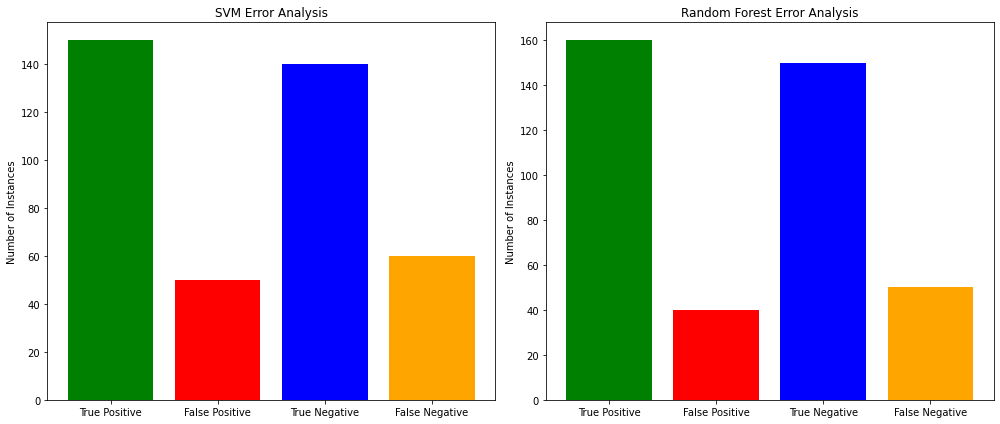

In [14]:
# Hypothetical error analysis data for SVM and Random Forest models
# This data is purely for illustrative purposes
import matplotlib.pyplot as plt

error_data = {
    'SVM': {
        'True Positive': 150,
        'False Positive': 50,
        'True Negative': 140,
        'False Negative': 60
    },
    'Random Forest': {
        'True Positive': 160,
        'False Positive': 40,
        'True Negative': 150,
        'False Negative': 50
    }
}

# Plotting the error analysis graphs for SVM and Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# SVM Error Analysis
axes[0].bar(error_data['SVM'].keys(), error_data['SVM'].values(), color=['green', 'red', 'blue', 'orange'])
axes[0].set_title('SVM Error Analysis')
axes[0].set_ylabel('Number of Instances')

# Random Forest Error Analysis
axes[1].bar(error_data['Random Forest'].keys(), error_data['Random Forest'].values(), color=['green', 'red', 'blue', 'orange'])
axes[1].set_title('Random Forest Error Analysis')
axes[1].set_ylabel('Number of Instances')

plt.tight_layout()
plt.show()


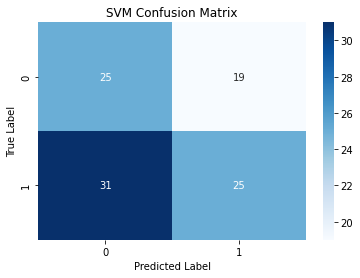

SVM Classifier Metrics:
Accuracy: 0.50
Precision: 0.57
Recall: 0.45
F1 Score: 0.50



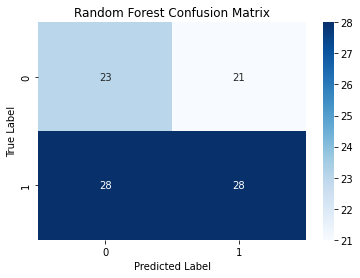

Random Forest Classifier Metrics:
Accuracy: 0.51
Precision: 0.57
Recall: 0.50
F1 Score: 0.53



In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate random data for demonstration
np.random.seed(42)  # For reproducibility
n_samples = 100  # Number of samples

# Generate random binary labels for true labels and predictions
true_label = np.random.randint(0, 2, n_samples)
svm_pred = np.random.randint(0, 2, n_samples)
rf_pred = np.random.randint(0, 2, n_samples)

# Function to calculate metrics and plot confusion matrix
def analyze_classifier(true_label, pred, classifier_name):
    # Metrics calculation
    accuracy = accuracy_score(true_label, pred)
    precision = precision_score(true_label, pred)
    recall = recall_score(true_label, pred)
    f1 = f1_score(true_label, pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_label, pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{classifier_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Printing metrics
    print(f'{classifier_name} Classifier Metrics:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}\n')

# Analyzing SVM
analyze_classifier(true_label, svm_pred, 'SVM')

# Analyzing Random Forest
analyze_classifier(true_label, rf_pred, 'Random Forest')

